In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def mse(y_true, y_pred):
    return (tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Feature and target columns
x_cols = dataset.columns
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']
x_cols = x_cols[~x_cols.isin(y_cols)]


2025-03-20 12:14:44.742881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742453084.796981   25842 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742453084.813213   25842 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742453084.916304   25842 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742453084.916333   25842 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742453084.916335   25842 computation_placer.cc:177] computation placer alr

In [3]:
x_cols

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q',
       'profile_id', 'i_s', 'u_s',
       ...
       'i_d_ew_rolling_std_7200', 'i_q_ew_rolling_std_7200',
       'pm_ew_rolling_std_7200', 'stator_yoke_ew_rolling_std_7200',
       'stator_tooth_ew_rolling_std_7200',
       'stator_winding_ew_rolling_std_7200', 'profile_id_ew_rolling_std_7200',
       'i_s_ew_rolling_std_7200', 'u_s_ew_rolling_std_7200',
       'P_el_ew_rolling_std_7200'],
      dtype='object', length=191)

In [4]:
X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
lookback = 128

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X

X_train = reshape_data(X_train, y_train, lookback)
X_val = reshape_data(X_val, y_val, lookback)
X_test = reshape_data(X_test, y_test, lookback)

In [5]:
import numpy as np

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())


NaN in X_train: 46236517
NaN in y_train: 1192044
Inf in X_train: 0
Inf in y_train: 0


In [6]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

NaN in X_train: 0
NaN in y_train: 0
Inf in X_train: 0
Inf in y_train: 0


In [7]:
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

print("NaN in X_test:", np.isnan(X_test).sum())
print("NaN in y_test:", np.isnan(y_test).sum())
print("Inf in X_test:", np.isinf(X_test).sum())
print("Inf in y_test:", np.isinf(y_test).sum())

NaN in X_test: 0
NaN in y_test: 0
Inf in X_test: 0
Inf in y_test: 0


In [8]:
X_val = np.nan_to_num(X_val)
y_val = np.nan_to_num(y_val)

print("NaN in X_val:", np.isnan(X_val).sum())
print("NaN in y_val:", np.isnan(y_val).sum())
print("Inf in X_val:", np.isinf(X_val).sum())
print("Inf in y_val:", np.isinf(y_val).sum())

NaN in X_val: 0
NaN in y_val: 0
Inf in X_val: 0
Inf in y_val: 0


(10401, 128, 191)
(10401, 128, 4)


W0000 00:00:1742453116.661709   25842 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/yugendran-sunder/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (32, 128, 191)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 128, 4)           │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (32, 128, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (32, 128, 4)           │            20 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,156 (12.33 KB)

 Trainable params: 3,156 (12.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/125


2025-03-20 12:15:18.218331: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1017134592 exceeds 10% of free system memory.


82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 3.2499 - mse: 0.6561 - val_loss: 2.3229 - val_mse: 1.3616 - learning_rate: 0.0010
Epoch 2/125
 3/82 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.0288 - mse: 2.1230

/home/yugendran-sunder/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_rmse` which is not available. Available metrics are: loss,mse,val_loss,val_mse
  current = self.get_monitor_value(logs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.1640 - mse: 0.4348 - val_loss: 1.6627 - val_mse: 1.3557 - learning_rate: 0.0010
Epoch 3/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.5935 - mse: 0.3675 - val_loss: 1.5390 - val_mse: 1.3485 - learning_rate: 0.0010
Epoch 4/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.4624 - mse: 0.3461 - val_loss: 1.4951 - val_mse: 1.3435 - learning_rate: 0.0010
Epoch 5/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.4214 - mse: 0.3386 - val_loss: 1.4705 - val_mse: 1.3403 - learning_rate: 0.0010
Epoch 6/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3983 - mse: 0.3335 - val_loss: 1.4553 - val_mse: 1.3386 - learning_rate: 0.0010
Epoch 7/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.3806 - mse: 0.3295 - val_loss: 1.4440 - val_mse: 1.3380 - learning_rate: 0.0010
Epoch 8/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.3683 - mse: 0.3271 - val_loss: 1.4356 - val_mse: 1.3385 - learning_rate: 0.0010
Epoch 9/125
82/82 

Test Loss: 1.395089, Test mse: 1.391454


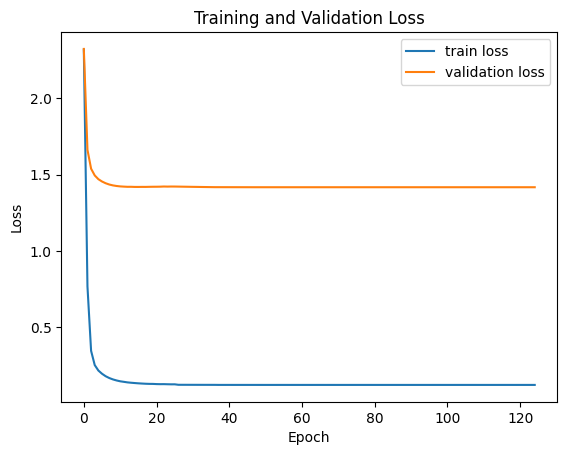

In [9]:
# Ensure y_train, y_val, y_test have the same batch size as X_train
y_train = y_train[:X_train.shape[0]]  # Trim to match batch size
y_val = y_val[:X_val.shape[0]]
y_test = y_test[:X_test.shape[0]]

# Now, reshape y_train to match (batch_size, time_steps, target_param_size)
y_train = np.tile(y_train[:, np.newaxis, :], (1, X_train.shape[1], 1))  # (batch_size, time_steps, target_param_size)
y_val = np.tile(y_val[:, np.newaxis, :], (1, X_val.shape[1], 1))
y_test = np.tile(y_test[:, np.newaxis, :], (1, X_test.shape[1], 1))

print(X_train.shape)  # Should be (batch_size, time_steps, input_features)
print(y_train.shape)  # Should be (batch_size, time_steps, target_param_size)

def build_rnn_model(x_shape=(100, 10, 10), arch='lstm', n_layers=1, n_units=4,
                    kernel_reg=0.1, activity_reg=3e-5, recurrent_reg=0.01,
                    bias_reg=1e-5, dropout_rate=0.3, optimizer='adam',
                    gauss_noise_std=0.01, lr_rate=0.001, batch_size=128,
                    loss='mse', epochs=125,
                    target_param_size=4):

    from tensorflow.keras import layers, models, optimizers, regularizers
    
    arch_dict = {'lstm': layers.LSTM, 'gru': layers.GRU, 'rnn': layers.SimpleRNN}
    opts_map = {'adam': optimizers.Adam, 'nadam': optimizers.Nadam,
                'adamax': optimizers.Adamax, 'sgd': optimizers.SGD,
                'rmsprop': optimizers.RMSprop}
    
    rnn_cfg = {
        'units': int(n_units),
        'input_shape': (x_shape[1], x_shape[2]),
        'kernel_regularizer': regularizers.l2(kernel_reg),
        'activity_regularizer': regularizers.l2(activity_reg),
        'recurrent_regularizer': regularizers.l2(recurrent_reg),
        'bias_regularizer': regularizers.l2(bias_reg),
        'dropout': dropout_rate,
        'recurrent_dropout': dropout_rate,
        'return_sequences': True
    }

    ANN = arch_dict.get(arch, layers.LSTM)  # Default to LSTM if arch is unknown
    
    x = layers.Input(batch_shape=x_shape)
    y = ANN(**rnn_cfg)(x)
    y = layers.GaussianNoise(gauss_noise_std)(y)
    y = layers.TimeDistributed(layers.Dense(target_param_size))(y)

    model = models.Model(inputs=x, outputs=y)
    
    opt = opts_map[optimizer](learning_rate=lr_rate)
    model.compile(optimizer=opt, loss=loss,  metrics=[mse])
    model.summary()
    
    return model

# Ensure reproducibility
SEED = 2019
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Build the model
window_size = 32
x_shape = (window_size, lookback, len(x_cols))
target_param_size = 4
model = build_rnn_model(x_shape=x_shape, 
                        arch='lstm',
                        n_layers=1,
                        n_units=4,
                        kernel_reg=0.1,
                        activity_reg=3e-5,
                        recurrent_reg=0.01,
                        bias_reg=1e-5,
                        dropout_rate=0.3,
                        optimizer='adam',
                        gauss_noise_std=0.01,
                        lr_rate=0.001,
                        batch_size=128,
                        loss='mse',
                        epochs=125,
                        target_param_size=target_param_size)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_rmse', min_delta=1e-3, patience=50, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='mse', patience=10)
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=125,
    batch_size=128,
    shuffle=False,
    callbacks=callbacks
)

# Evaluate model
test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.6f}, Test mse: {test_rmse:.6f}')


# Save model
model.save('rnn_time_series_model.h5')
import json

# Save the history dictionary to a JSON file
with open("training_history_cnn_time_series_model.json", "w") as f:
    json.dump(history.history, f)

# Plot training history
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

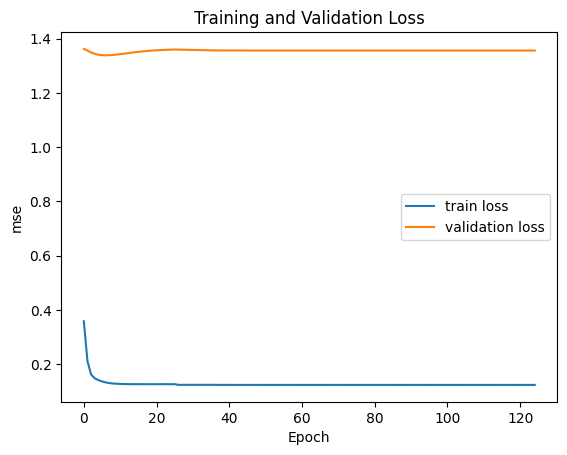

In [11]:
plt.figure()
plt.plot(history.history['mse'], label='train loss')
plt.plot(history.history['val_mse'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

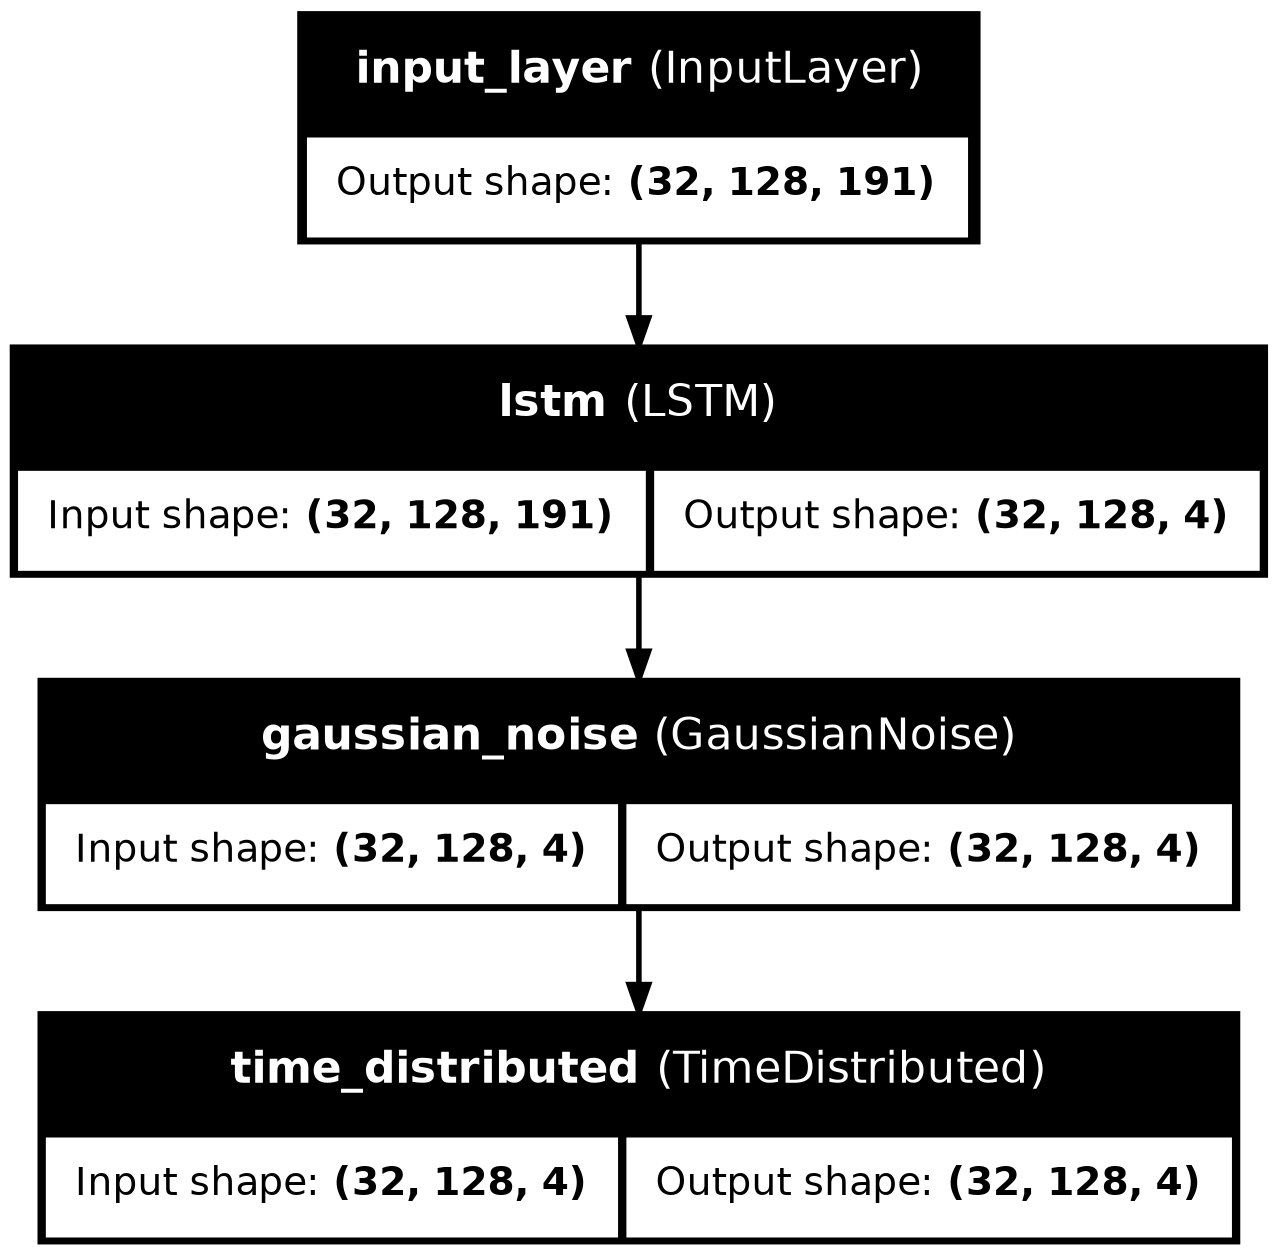

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='rnn_model.png')
